# SETUP:

In [1]:
#%pip install --upgrade pip setuptools wheel

### Sanity Test:

In [2]:
import sys
print("verifying use of Virtual Environment:")
print(sys.executable)


verifying use of Virtual Environment:
/home/renegade/Dev/jupyter/notebookenv/bin/python


## Install Dependecies

In [3]:
#%pip install matplotlib tensorflow-io tensorflow --upgrade


## Import and Set Libraries

In [17]:
import os
import sys
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Define Paths to Files

In [18]:
# Data we want to use as a specific, yes (1), this is a Kick
KICK_FILE = os.path.join('data', 'parsed', 'Kicks', 'ALC_Kick_03.wav')
# Data we want to use as a specific, NO (0), this is not a Kick
NOT_KICK = os.path.join('data', 'parsed', 'Synth-plucks', 'Cymatics_-_Hybrid_Trap_Synth_One_Shot_3_-_E.wav')

In [19]:
NOT_KICK

'data/parsed/Synth-plucks/Cymatics_-_Hybrid_Trap_Synth_One_Shot_3_-_E.wav'

# App starts:

In [20]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode WAV (Tensors by Channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Remove Trailing Axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44.1Khz to 16Khz - Amplitude of Audio Signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav
    ### Can use tfio.audio.decode_wav(tf.io.read_file('24-bit.wav'), dtype=tf.int32)) for 24k files

### Plot WAVE

In [23]:
wave = load_wav_16k_mono(KICK_FILE)
nwave = load_wav_16k_mono(NOT_KICK)

<function matplotlib.pyplot.show(close=None, block=None)>

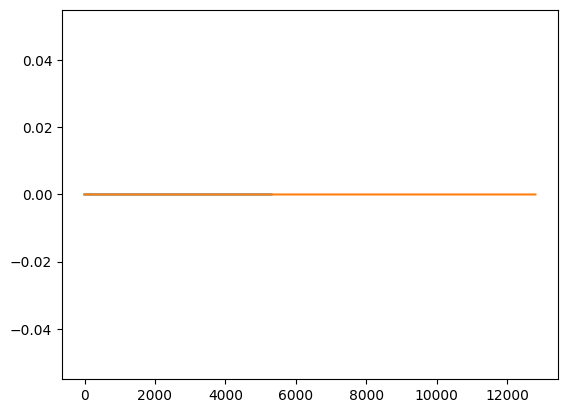

In [24]:
plt.plot(wave)
plt.plot(nwave)
plt.show

In [26]:
POS = os.path.join('data', 'parsed', 'Kicks')
NEG = os.path.join('data', 'parsed', 'Synth-plucks')

In [29]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [30]:
# Add Labels and Combine Pos and Neg samples

In [32]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

data = positives.concatenate(negatives)

In [70]:
negatives.as_numpy_iterator().next()

(b'data/parsed/Synth-plucks/TT_synth_v_simple.wav', 0.0)

In [71]:
# Determine Average Length of Kick

In [75]:
lengths = []
for file in os.listdir(os.path.join('data', 'parsed', 'Kicks')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'parsed', 'Kicks', file))
    lengths.append(len(tensor_wave))

In [76]:
lengths

[5344, 5308, 5656, 4597, 11888, 11888, 5543, 10520]

In [ ]:
# Calculate Mean, Min, Max

In [77]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=7593>

In [78]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=4597>

In [79]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=11888>

## Build Preprocessing Function to Convert to Spectrogram

In [81]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

### test out and viz spectogram

In [82]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [83]:
spectrogram, label = preprocess(filepath, label)

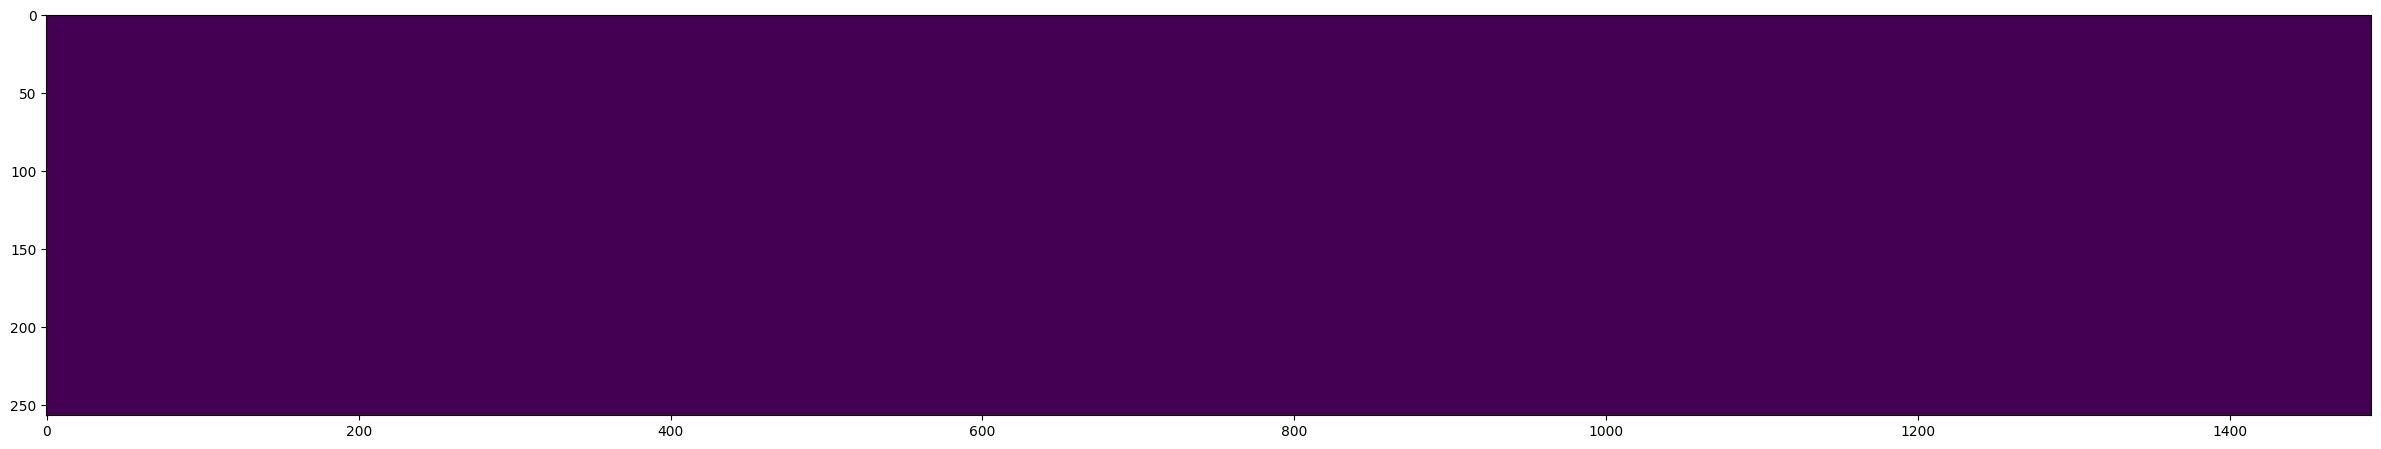

In [84]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()
